# Deep Learning and Applied AI project (part2)
### Author: Ahmedeo Shokry
### Student number: 1750037

In this second part of the project I will study the disentagling behaviour of a VAE when the encoder part is replaced with a GCNN. Intuitively the idea is to make the encoder invariant w.r.t the image rotation and help the whole training process by increasing the weight sharing exploiting the GCNN architecture. Also I decided to add a geometrical constrain to the latent space since in lower dimensions (<10) it leads to a better redistribution of the latent points on the whole surface [1]. \
In particular in the following notebook I'll construct the VAE with a GCNN encoder and I will test its performace on random rotated MNIST images in order to verify if the model is effectively capable of disentagle the image itself from its rotation. \
[1]: T. R. Davidson, L. Falorsi, N. D. Cao, T. Kipf, J. M. Tomczak. Hyperspherical Variational Auto-Encoders (2018) (https://arxiv.org/pdf/1804.00891.pdf)

In [1]:
# Define the device to use.
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cuda


Install geomstats library, seful later when I have to define geodesics on the hypersphere.

In [2]:
!pip install geomstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.5 MB/s eta 0:00:0000:0100:01


Install escnn library to implement the GCNN encoder.

In [3]:
!pip install escnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.3/350.3 kB 7.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 63.2 MB/s eta 0:00:0000:0100:01


In [4]:
# Import dependencies.
from typing import Mapping, Union, Optional, Callable
from pathlib import Path
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
import os
import pickle
from tqdm.notebook import tqdm
import escnn
from escnn import gspaces
import escnn.nn as nn_escnn

In [5]:
# For reproducibility.
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Just a function to count the number of parameters.
def count_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
# Define the hyperparameters.
num_epochs = 50
batch_size = 100
learning_rate = 1e-2
beta = 0.1
latent_dim = 6
freq = 6 # For the G-CNN model

In [8]:
from torchvision.datasets import MNIST
from torchvision.transforms import Pad
from torchvision.transforms import RandomRotation, Resize, Normalize
from sklearn.model_selection import train_test_split

# Padding the original image in order to better center the digit.
pad = Pad((0, 0, 4, 4), fill=0)

# Before normalize the dataset check the mean and std, then normalize it.
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width.
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1   
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std


# Train set
train_transform = transforms.Compose([
    transforms.ToTensor(),
    pad,
    # Since I added some padding the statistics are changed. 
    # I had to recalculate mean and std (using just the train dataloader),
    # that's why they are different from the knwon values for MNIST.
    transforms.Normalize((0.1008,), (0.2765,)) 
])

# Test set (the rotated one)
rot_transform = transforms.Compose([
    transforms.ToTensor(),
    pad,
    # To reduce interpolation artifacts.
    Resize(96), # to upsample.
    RandomRotation(180.),
    Resize(32), # to downsample.
    transforms.Normalize((0.1008,), (0.2765,)) # Same normalization here.
    
])

# MNIST dataset.
train_dataset = MNIST(root='./data', download=True, train=True, transform=train_transform)
test_set_rot = MNIST(root='./data', download=True, train=False, transform=rot_transform)

# Here I perform the stratified splitting between train and validation set.
targets = train_dataset.targets[:35000] # We can choose a subset of the entire train_set
train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=1/7, shuffle=True, stratify=targets)

# Create sampler using the index found above
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# Define the dataloaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_dataloader = DataLoader(test_set_rot, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
# Retrieve some images and labels in the last batch.
train_im, train_lab = next(iter(train_dataloader))
test_im, test_lab = next(iter(test_dataloader))

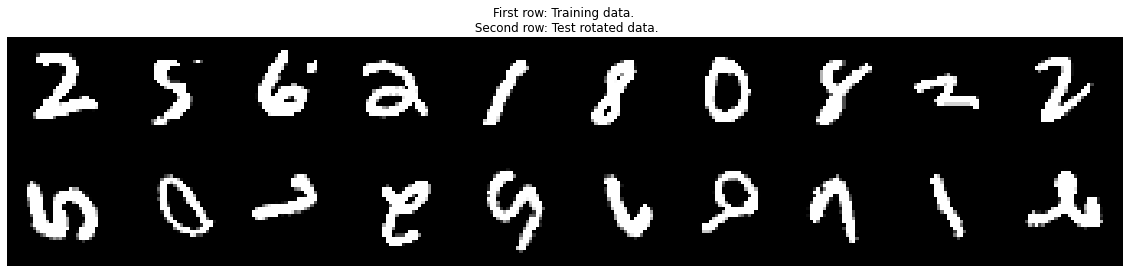

In [10]:
# Plot some train and test image.
m = np.random.randint(0,batch_size-1,10)
plt.figure(figsize=(20,12))
plt.imshow(torchvision.utils.make_grid(torch.cat((train_im[m,...],test_im[m,...]), 0), 10, 2).permute(1, 2, 0))
plt.title("First row: Training data. \n Second row: Test rotated data.")
plt.axis('off')
plt.show()

# VAE (GCNN)

In [10]:
# Implement the encoder.
class GCNN_encoder(torch.nn.Module):
    def __init__(self, latent_dim=latent_dim, freq=freq) -> None:
        super().__init__()
        # SO(2) group
        self.r2_act = gspaces.rot2dOnR2(N=-1)
        # The input image is a scalar field.
        in_type = nn_escnn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.input_type = in_type
        # Mask the input corner to preserve equivariance when a rotated image is given.
        self.mask = nn_escnn.MaskModule(in_type, 32, margin=1) 
        # Convolution 1.
        # Each block is approximately equivariant.
        activation1 = nn_escnn.FourierELU(self.r2_act, 64, irreps=[(f,) for f in range(freq)], N=16, inplace=True)
        # SO(2) group is has an infinite number of irreps each of them representing a unique frequency, with "freq"
        # we can specify how many irreps we want to use.
        # N in fourierELU specify the number of point for the discretization grid when fourier transform is computed.
        out_type = activation1.in_type
        self.block1 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=4, stride=2, padding=0, bias=False), # G-steerable conv.
            activation1,
            nn_escnn.IIDBatchNorm2d(out_type),
            nn_escnn.FieldDropout(out_type, 0.1) # Applies dropout to individual fields independently.
        )
        # Convolution 2.
        in_type = self.block1.out_type
        activation2 = nn_escnn.FourierELU(self.r2_act, 64, irreps=[(f,) for f in range(freq)], N=16, inplace=True)
        out_type = activation2.in_type
        self.block2 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=4, stride=1, padding=0, bias=False),
            activation2,
            nn_escnn.IIDBatchNorm2d(out_type),
            nn_escnn.FieldDropout(out_type, 0.1)
        )
        # Convolution 3.
        in_type = self.block2.out_type
        activation3 = nn_escnn.FourierELU(self.r2_act, 128, irreps=[(f,) for f in range(freq)], N=16, inplace=True)
        out_type = activation3.in_type
        self.block3 = nn_escnn.SequentialModule(
            nn_escnn.R2Conv(in_type, out_type, kernel_size=4, stride=2, padding=0, bias=False),
            activation3,
            nn_escnn.IIDBatchNorm2d(out_type),
            nn_escnn.FieldDropout(out_type, 0.1)
        )
        # Strided conv. with a gaussian blur filter (sigma is the std of the gaussian).
        self.pool3 = nn_escnn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        # Number of output invariant channels.
        c = 128
        output_invariant_type = nn_escnn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr]) # Output field type
        # Implementing the G-convolution in order to extract the invariant maps
        self.invariant_map = nn_escnn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False) 

        # Compute mean and concentration of the von Mises-Fisher.
        self.fc_mean = nn.Sequential(
            nn.ELU(),
            nn.BatchNorm1d(c),
            nn.Dropout(0.2),
            nn.Linear(c, latent_dim),
        )     
        self.fc_conc = nn.Sequential(
            nn.ELU(),
            nn.BatchNorm1d(c),
            nn.Dropout(0.2),
            nn.Linear(c, 1),
        )          

    def forward(self, input: torch.Tensor):
        # Wrap the input tensor in a GeometricTensor (input type).
        x = self.input_type(input)
        x = self.mask(x)
        # Apply each equivariant block.
        x = self.block1(x)
        x = self.block2(x)        
        x = self.block3(x)
        # Pool over the spatial dimensions.
        x = self.pool3(x)
        # Extract invariant features.
        x = self.invariant_map(x) 
        # Unwrap the output GeometricTensor.
        x = x.tensor
        # Compute mean and concentration of the von Mises-Fisher.
        mu = self.fc_mean(x.reshape(x.shape[0], -1))
        mu = mu / mu.norm(dim=-1, keepdim=True)
        # The `+ 1` prevent collapsing behaviors.
        conc = F.softplus(self.fc_conc(x.reshape(x.shape[0], -1))) + 1

        return mu, conc
    
# Implement the decoder.
class CNN_decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim) -> None:
        super().__init__()

        self.fc = nn.Linear(latent_dim, 128 * 5 * 5)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=0)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=0)
        
        self.do1 = nn.Dropout(0.1)
        self.do2 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(128*5*5)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Fully connected layer.
        x = self.fc(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.do1(x)
        x = x.view(x.size(0), 128, 5, 5)
        # First convolution.
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.do2(x)
        # Second convolution.
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.do2(x)
        # Third convolution.
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.do2(x)
        return x

In [11]:
# Here I define the whole variational autoencoder
class GCNN_VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim, freq):
        super().__init__()
        self.encoder = GCNN_encoder(latent_dim, freq)
        self.decoder = CNN_decoder(latent_dim)
    
    def forward(self, x):
        mu, conc = self.encoder(x)
        q_z, p_z = self.reparameterize(mu, conc)
        z = q_z.rsample() # In order to properly backpropagate.
        x_recon = self.decoder(z)
        return (mu, conc), (q_z, p_z), z, x_recon
    
    def reparameterize(self, mu, conc):
        q_z = VonMisesFisher(mu, conc)
        p_z = HypersphericalUniform(latent_dim - 1)
        return q_z, p_z

In [12]:
def vae_loss(recon_x, x, q_z, p_z):
    recon_loss = F.mse_loss(recon_x.view(-1, 1024), x.view(-1, 1024), reduction='sum') 
    KLD = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
    return recon_loss + beta * KLD

In [13]:
# This function averages the losse value during the training.
def make_averager() -> Callable[[Optional[float]], float]:
    count = 0
    total = 0
    def averager(new_value: Optional[float]) -> float:
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count
    return averager

# At the end of the training I plot the train and validation losses
def plot_loss(loss1, loss2):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=list(range(len(loss1))), 
                   y=loss1)
    )
    fig.add_trace(
        go.Scatter(x=list(range(len(loss2))),
                   y=loss2)
    )
    fig.update_layout(
        title="Train and test loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        height=600, width=1200,
    )
    return fig

# Refresh the tqdm bar
def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()

# Retrive a reconstructed image from the input image.
def rec_image(images, model):
    with torch.no_grad():
        _, _, _, images_latent = model(images.to(device))
    return images_latent

# Utility function to implement vMF distribution, backprop and reparam trick.

All these codes can be found here: https://github.com/nicola-decao/s-vae-tf

In [14]:
# HypersphericalUniform class for sampling using vmf distribution
import math
import torch

class HypersphericalUniform(torch.distributions.Distribution):

    support = torch.distributions.constraints.real
    has_rsample = False
    _mean_carrier_measure = 0

    @property
    def dim(self):
        return self._dim

    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, val):
        self._device = val if isinstance(val, torch.device) else torch.device(val)

    def __init__(self, dim, validate_args=None, device="cuda"):
        super(HypersphericalUniform, self).__init__(
            torch.Size([dim]), validate_args=validate_args
        )
        self._dim = dim
        self.device = device

    def sample(self, shape=torch.Size()):
        output = (
            torch.distributions.Normal(0, 1)
            .sample(
                (shape if isinstance(shape, torch.Size) else torch.Size([shape]))
                + torch.Size([self._dim + 1])
            )
            .to(self.device)
        )

        return output / output.norm(dim=-1, keepdim=True)

    def entropy(self):
        return self.__log_surface_area()

    def log_prob(self, x):
        return -torch.ones(x.shape[:-1], device=self.device) * self.__log_surface_area()

    def __log_surface_area(self):
        if torch.__version__ >= "1.0.0":
            lgamma = torch.lgamma(torch.tensor([(self._dim + 1) / 2]).to(self.device))
        else:
            lgamma = torch.lgamma(
                torch.Tensor([(self._dim + 1) / 2], device=self.device)
            )
        return math.log(2) + ((self._dim + 1) / 2) * math.log(math.pi) - lgamma


arg_constraints = {}

In [15]:
# VonMisesFisher class for computing its mean and variance 
from torch.distributions.kl import register_kl

class VonMisesFisher(torch.distributions.Distribution):

    arg_constraints = {
        "loc": torch.distributions.constraints.real,
        "scale": torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        # option 1:
        #return self.loc * (
            #ive(self.__m / 2, self.scale) / ive(self.__m / 2 - 1, self.scale)
        #)
        # option 2:
        return self.loc * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # options 3:
        # return self.loc * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

    @property
    def stddev(self):
        return self.scale

    def __init__(self, loc, scale, validate_args=None, k=1):
        self.dtype = loc.dtype
        self.loc = loc
        self.scale = scale
        self.device = loc.device
        self.__m = loc.shape[-1]
        self.__e1 = (torch.Tensor([1.0] + [0] * (loc.shape[-1] - 1))).to(self.device)
        self.k = k

        super().__init__(self.loc.size(), validate_args=validate_args)

    def sample(self, shape=torch.Size()):
        with torch.no_grad():
            return self.rsample(shape)

    def rsample(self, shape=torch.Size()):
        shape = shape if isinstance(shape, torch.Size) else torch.Size([shape])

        w = (
            self.__sample_w3(shape=shape)
            if self.__m == 3
            else self.__sample_w_rej(shape=shape)
        )

        v = (
            torch.distributions.Normal(0, 1)
            .sample(shape + torch.Size(self.loc.shape))
            .to(self.device)
            .transpose(0, -1)[1:]
        ).transpose(0, -1)
        v = v / v.norm(dim=-1, keepdim=True)

        w_ = torch.sqrt(torch.clamp(1 - (w ** 2), 1e-10))
        x = torch.cat((w, w_ * v), -1)
        z = self.__householder_rotation(x)

        return z.type(self.dtype)

    def __sample_w3(self, shape):
        shape = shape + torch.Size(self.scale.shape)
        u = torch.distributions.Uniform(0, 1).sample(shape).to(self.device)
        self.__w = (
            1
            + torch.stack(
                [torch.log(u), torch.log(1 - u) - 2 * self.scale], dim=0
            ).logsumexp(0)
            / self.scale
        )
        return self.__w

    def __sample_w_rej(self, shape):
        c = torch.sqrt((4 * (self.scale ** 2)) + (self.__m - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.__m - 1)

        # using Taylor approximation with a smooth swift from 10 < scale < 11
        # to avoid numerical errors for large scale
        b_app = (self.__m - 1) / (4 * self.scale)
        s = torch.min(
            torch.max(
                torch.tensor([0.0], dtype=self.dtype, device=self.device),
                self.scale - 10,
            ),
            torch.tensor([1.0], dtype=self.dtype, device=self.device),
        )
        b = b_app * s + b_true * (1 - s)

        a = (self.__m - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.__m - 1) * math.log(self.__m - 1)

        self.__b, (self.__e, self.__w) = b, self.__while_loop(b, a, d, shape, k=self.k)
        return self.__w

    @staticmethod
    def first_nonzero(x, dim, invalid_val=-1):
        mask = x > 0
        idx = torch.where(
            mask.any(dim=dim),
            mask.float().argmax(dim=1).squeeze(),
            torch.tensor(invalid_val, device=x.device),
        )
        return idx

    def __while_loop(self, b, a, d, shape, k=20, eps=1e-20):
        #  matrix while loop: samples a matrix of [A, k] samples, to avoid looping all together
        b, a, d = [
            e.repeat(*shape, *([1] * len(self.scale.shape))).reshape(-1, 1)
            for e in (b, a, d)
        ]
        w, e, bool_mask = (
            torch.zeros_like(b).to(self.device),
            torch.zeros_like(b).to(self.device),
            (torch.ones_like(b) == 1).to(self.device),
        )

        sample_shape = torch.Size([b.shape[0], k])
        shape = shape + torch.Size(self.scale.shape)

        while bool_mask.sum() != 0:
            con1 = torch.tensor((self.__m - 1) / 2, dtype=torch.float64)
            con2 = torch.tensor((self.__m - 1) / 2, dtype=torch.float64)
            e_ = (
                torch.distributions.Beta(con1, con2)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            u = (
                torch.distributions.Uniform(0 + eps, 1 - eps)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            w_ = (1 - (1 + b) * e_) / (1 - (1 - b) * e_)
            t = (2 * a * b) / (1 - (1 - b) * e_)

            accept = ((self.__m - 1.0) * t.log() - t + d) > torch.log(u)
            accept_idx = self.first_nonzero(accept, dim=-1, invalid_val=-1).unsqueeze(1)
            accept_idx_clamped = accept_idx.clamp(0)
            # we use .abs(), in order to not get -1 index issues, the -1 is still used afterwards
            w_ = w_.gather(1, accept_idx_clamped.view(-1, 1))
            e_ = e_.gather(1, accept_idx_clamped.view(-1, 1))

            reject = accept_idx < 0
            accept = ~reject if torch.__version__ >= "1.2.0" else 1 - reject

            w[bool_mask * accept] = w_[bool_mask * accept]
            e[bool_mask * accept] = e_[bool_mask * accept]

            bool_mask[bool_mask * accept] = reject[bool_mask * accept]

        return e.reshape(shape), w.reshape(shape)

    def __householder_rotation(self, x):
        u = self.__e1 - self.loc
        u = u / (u.norm(dim=-1, keepdim=True) + 1e-5)
        z = x - 2 * (x * u).sum(-1, keepdim=True) * u
        return z

    def entropy(self):
        # option 1:
        # output = (
        #     -self.scale
        #     * ive(self.__m / 2, self.scale)
        #     / ive((self.__m / 2) - 1, self.scale)
        # )
        # option 2:
        output = - self.scale * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # option 3:
        # output = - self.scale * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

        return output.view(*(output.shape[:-1])) + self._log_normalization()

    def log_prob(self, x):
        return self._log_unnormalized_prob(x) - self._log_normalization()

    def _log_unnormalized_prob(self, x):
        output = self.scale * (self.loc * x).sum(-1, keepdim=True)

        return output.view(*(output.shape[:-1]))

    def _log_normalization(self):
        output = -(
            (self.__m / 2 - 1) * torch.log(self.scale)
            - (self.__m / 2) * math.log(2 * math.pi)
            - (self.scale + torch.log(ive(self.__m / 2 - 1, self.scale)))
        )

        return output.view(*(output.shape[:-1]))


@register_kl(VonMisesFisher, HypersphericalUniform)
def _kl_vmf_uniform(vmf, hyu):
    return -vmf.entropy() + hyu.entropy()

In [16]:
# Ive class for Bessel funcions and some stable variations
import scipy.special
from numbers import Number


class IveFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, v, z):

        assert isinstance(v, Number), "v must be a scalar"

        self.save_for_backward(z)
        self.v = v
        z_cpu = z.data.cpu().numpy()

        if np.isclose(v, 0):
            output = scipy.special.i0e(z_cpu, dtype=z_cpu.dtype)
        elif np.isclose(v, 1):
            output = scipy.special.i1e(z_cpu, dtype=z_cpu.dtype)
        else:  #  v > 0
            output = scipy.special.ive(v, z_cpu, dtype=z_cpu.dtype)
        #         else:
        #             print(v, type(v), np.isclose(v, 0))
        #             raise RuntimeError('v must be >= 0, it is {}'.format(v))

        return torch.Tensor(output).to(z.device)

    @staticmethod
    def backward(self, grad_output):
        z = self.saved_tensors[-1]
        return (
            None,
            grad_output * (ive(self.v - 1, z) - ive(self.v, z) * (self.v + z) / z),
        )


class Ive(torch.nn.Module):
    def __init__(self, v):
        super(Ive, self).__init__()
        self.v = v

    def forward(self, z):
        return ive(self.v, z)


ive = IveFunction.apply


##########
# The below provided approximations were provided in the
# respective source papers, to improve the stability of
# the Bessel fractions.
# I_(v/2)(k) / I_(v/2 - 1)(k)

# source: https://arxiv.org/pdf/1606.02008.pdf
def ive_fraction_approx(v, z):
    # I_(v/2)(k) / I_(v/2 - 1)(k) >= z / (v-1 + ((v+1)^2 + z^2)^0.5
    return z / (v - 1 + torch.pow(torch.pow(v + 1, 2) + torch.pow(z, 2), 0.5))


# source: https://arxiv.org/pdf/1902.02603.pdf
def ive_fraction_approx2(v, z, eps=1e-20):
    def delta_a(a):
        lamb = v + (a - 1.0) / 2.0
        return (v - 0.5) + lamb / (
            2 * torch.sqrt((torch.pow(lamb, 2) + torch.pow(z, 2)).clamp(eps))
        )

    delta_0 = delta_a(0.0)
    delta_2 = delta_a(2.0)
    B_0 = z / (
        delta_0 + torch.sqrt((torch.pow(delta_0, 2) + torch.pow(z, 2))).clamp(eps)
    )
    B_2 = z / (
        delta_2 + torch.sqrt((torch.pow(delta_2, 2) + torch.pow(z, 2))).clamp(eps)
    )

    return (B_0 + B_2) / 2.0

## Training

Here I instantiate the model the optimizer, the scheduler learning rate and print the number of parameters.

In [ ]:
#Initialize the variational autoencoder (don't if you have already a checkpoint)
gcnn_vae = GCNN_VariationalAutoencoder(latent_dim=latent_dim, freq=freq)
gcnn_vae = gcnn_vae.to(device)
optimizer = torch.optim.Adam(params=gcnn_vae.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

print('Number of parameters: %d' % count_parameters(gcnn_vae))

In [ ]:
# List to keep track of the train and validation loss.
train_loss_avg = []
valid_loss_avg = []
print('Training ...')
# Epoch tqdm bar.
tqdm_bar = tqdm(range(0, num_epochs), desc="Epoch [Loss: ...]")
for epoch in tqdm_bar:
    # Set to training mode.
    gcnn_vae.train()
    # To average the loss for every batch.
    train_loss_averager = make_averager()
    valid_loss_averager = make_averager()
    # Train batch tqdm bar.
    batch_bar =  tqdm(train_dataloader, leave=False, desc='Batch', total=len(train_dataloader))
    for image_batch, _ in batch_bar:
        # Send the image batch to device.
        image_batch = image_batch.to(device)
        # Vae reconstruction
        (z_mean, z_var), (q_z, p_z), z, image_batch_recon = gcnn_vae(image_batch)
        # Vae loss computation.
        loss = vae_loss(image_batch_recon, image_batch, q_z, p_z) 
        # Backpropagation.
        optimizer.zero_grad()
        loss.backward() 
        # Optimizer step.
        optimizer.step()
        refresh_bar(batch_bar, f"Train Batch [Train Loss: {train_loss_averager(loss.item()):.3f}]")
    # Validation Step.
    with torch.no_grad():
        # Set to eval mode.
        gcnn_vae.eval()
        # Validation batch tqdm bar.
        valid_batch_bar =  tqdm(valid_dataloader, leave=False, desc='Batch', total=len(valid_dataloader))
        for valid_batch_x, _ in valid_batch_bar:
            # Send to device.
            valid_batch_x = valid_batch_x.to(device)
            # Vae reconstruction.
            (z_mean_val, z_var_val), (q_z_val, p_z_val), z_val, valid_batch_recon = gcnn_vae(valid_batch_x)
            # Loss computation.
            loss_valid = vae_loss(valid_batch_recon, valid_batch_x, q_z_val, p_z_val)
            refresh_bar(valid_batch_bar, f"Test batch [Valid Loss: {valid_loss_averager(loss_valid.item()):.3f}]")
    # Lr. step.
    scheduler.step()
    # Append the loss value.
    train_loss_avg.append(train_loss_averager(None))
    valid_loss_avg.append(valid_loss_averager(None))
    
    refresh_bar(tqdm_bar, f"Epoch [Train loss: {train_loss_averager(None):.3f}, \
    Valid loss: {valid_loss_averager(None):.3f}, \
    Lr: {torch.tensor(scheduler.get_last_lr()).item():.5f}]") 
    # Visualize the generated images every epoch.
    rec_images = rec_image(valid_batch_x, gcnn_vae).cpu()
    plt.figure(figsize=(17,17))
    plt.imshow(torchvision.utils.make_grid(torch.cat((valid_batch_x.cpu()[:10,...],rec_images[:10,...]), 0),10,2).permute(1, 2, 0))
    plt.title("First 2 rows: Real images. \n Second 2 rows: Reconstructed images.")
    plt.axis('off')
    plt.show()
# At the end plot a train vs validation loss .
plot_loss(train_loss_avg, valid_loss_avg)

### Save the trained model

In [ ]:
# Saving a checkpoint
checkpoint = {'train_loss': train_loss_avg,
              'valid_loss' : valid_loss_avg,
              'num_epochs': num_epochs,
              'batch_size': batch_size,
              'learning_rate': learning_rate,
              'beta': beta,
              'latent_dim': latent_dim,
              'freq': freq}

torch.save(checkpoint, 'checkpointSGCNNVAE_MNIST_32_epoch100.pth')
torch.save(gcnn_vae.state_dict(), 'model_checkpointSGCNNVAE_MNIST_32_epoch100.pth')

### Load the pretrained model

In [37]:
# Load and initialize the model.
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    train_loss = checkpoint['train_loss']
    valid_loss = checkpoint['valid_loss']
    num_epochs = checkpoint['num_epochs']
    batch_size = checkpoint['batch_size']
    learning_rate = checkpoint['learning_rate']
    beta = checkpoint['beta']
    latent_dim = checkpoint['latent_dim']
    freq = checkpoint['freq']
    return train_loss, valid_loss, num_epochs, batch_size, learning_rate, beta, latent_dim, freq

# Load model hyperparametes.
train_loss_avg, valid_loss_avg, num_epochs, batch_size, learning_rate, beta, \
latent_dim, freq = load_checkpoint('../input/sgcnnvae/checkpointSGCNNVAE_MNIST_32_beta01_6.pth')
# Instantiate the model.
gcnn_vae = GCNN_VariationalAutoencoder(latent_dim=latent_dim, freq=freq)
# Load the state_dict model.
gcnn_vae.load_state_dict(torch.load('../input/sgcnnvae/model_checkpointSGCNNVAE_MNIST_32_beta01_6.pth'))
# Define the optimizer and the scheduler.
optimizer = torch.optim.Adam(params=gcnn_vae.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
gcnn_vae = gcnn_vae.to(device)

In [18]:
# Load losses.
def load_loss(filepath):
    checkpoint = torch.load(filepath)
    valid_loss_avg001 = checkpoint['valid_loss_avg001']
    valid_loss_avg01 = checkpoint['valid_loss_avg01']
    valid_loss_avg1 = checkpoint['valid_loss_avg1']
    valid_loss_avg150 = checkpoint['valid_loss_avg150']
    valid_loss_avg500 = checkpoint['valid_loss_avg500']
    valid_loss_avg001_6 = checkpoint['valid_loss_avg001_6']
    valid_loss_avg01_6 = checkpoint['valid_loss_avg01_6']
    valid_loss_avg1_6 = checkpoint['valid_loss_avg1_6']
    valid_loss_avg150_6 = checkpoint['valid_loss_avg150_6']
    valid_loss_avg500_6 = checkpoint['valid_loss_avg500_6']
    valid_loss_avg001_10 = checkpoint['valid_loss_avg001_10']
    valid_loss_avg01_10 = checkpoint['valid_loss_avg01_10']
    valid_loss_avg1_10 = checkpoint['valid_loss_avg1_10']
    valid_loss_avg150_10 = checkpoint['valid_loss_avg150_10']
    valid_loss_avg500_10 = checkpoint['valid_loss_avg500_10']
    
    return valid_loss_avg001, valid_loss_avg01, valid_loss_avg1, valid_loss_avg150, valid_loss_avg500, \
    valid_loss_avg001_6,valid_loss_avg01_6, valid_loss_avg1_6, valid_loss_avg150_6, valid_loss_avg500_6,\
    valid_loss_avg001_10, valid_loss_avg01_10, valid_loss_avg1_10, valid_loss_avg150_10, valid_loss_avg500_10

valid_loss_avg001, valid_loss_avg01, valid_loss_avg1, valid_loss_avg150, valid_loss_avg500, \
valid_loss_avg001_6, valid_loss_avg01_6, valid_loss_avg1_6, valid_loss_avg150_6, \
valid_loss_avg500_6, valid_loss_avg001_10, valid_loss_avg01_10, valid_loss_avg1_10, \
valid_loss_avg150_10, valid_loss_avg500_10 = load_loss('../input/sgcnnvae/losses.pth')

In [19]:
# Fixing latent dimension = 3
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg001))), y=valid_loss_avg001, name='beta=0.01'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01))), y=valid_loss_avg01, name='beta=0.1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg1))), y=valid_loss_avg1, name='beta=1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg150))), y=valid_loss_avg150, name='beta=150'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg500))), y=valid_loss_avg500, name='beta=500'))

fig.update_layout( title="Validation loss with latent dim fixed at 3.",
                  xaxis_title="Epoch",
                  yaxis_title="Loss",
                  height=600, width=1200,
                 )
iplot(fig)

In [20]:
# Fixing latent dimension = 6
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_6))), y=valid_loss_avg001_6, name='beta=00.1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_6))), y=valid_loss_avg01_6, name='beta=0.1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_6))), y=valid_loss_avg1_6, name='beta=1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg150_6))), y=valid_loss_avg150_6, name='beta=150'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg500_6))), y=valid_loss_avg500_6, name='beta=500'))

fig.update_layout( title="Validation loss with latent dim fixed at 6.",
                  xaxis_title="Epoch",
                  yaxis_title="Loss",
                  height=600, width=1200,
                 )
iplot(fig)

In [21]:
# Fixing latent dimension = 10
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_10))), y=valid_loss_avg001_10, name='beta=0.01'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_10))), y=valid_loss_avg01_10, name='beta=0.1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg01_10))), y=valid_loss_avg1_10, name='beta=1'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg150_10))), y=valid_loss_avg150_10, name='beta=150'))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss_avg500_10))), y=valid_loss_avg500_10, name='beta=500'))

fig.update_layout( title="Validation loss with latent dim fixed at 10.",
                  xaxis_title="Epoch",
                  yaxis_title="Loss",
                  height=600, width=1200,
                 )
iplot(fig)

# Disentangling ability 
(The analysis shown below are referred to the configuration $\beta$ = 0.1 and latent dimension = 3, except when explicitly stated.)

 ### $S^2$ latent space visualization (possible only when latent dimension = 3)

Here I show the distribution of the latent points on the sphere

In [22]:
# Here I define a function that gives a dataframe where the latent points coordinate
# and std of a given dataset are collected.
def hyperspherical_latent(model, data, num_batches):
    model= model.cpu()
    std = []
    z_x = []
    z_y = []
    z_z = []
    labels = []
    for i, (x, y) in enumerate(data):        
        if i == num_batches:
            break
        else:
            z_coords, z_other = model.encoder(x.cpu())
            z_coords = z_coords.detach()
            z_x.append(z_coords[:, 0])
            z_y.append(z_coords[:, 1])
            z_z.append(z_coords[:, 2])
            std.append(z_other.detach().numpy())
            labels.append(y.data.numpy().astype(str))

    std = np.concatenate(std)
    z_x = np.concatenate(z_x)
    z_y = np.concatenate(z_y)
    z_z = np.concatenate(z_z)
    labels = np.concatenate(labels)
    df = pd.DataFrame()
    df['index'] = np.arange(len(z_x))
    df['std'] = std
    df['class'] = labels
    df['mu_x'] = z_x
    df['mu_y'] = z_y
    df['mu_z'] = z_z     
    return df
# Retrive the latent points for train and test set.  
df_train = hyperspherical_latent(gcnn_vae, train_dataloader, num_batches=30)
df_test = hyperspherical_latent(gcnn_vae, test_dataloader, num_batches=30)

In [23]:
# Plot latent space of the SVAE model for train data
fig = px.scatter_3d(df_train, x="mu_x", y="mu_y", z = "mu_z",
                    size='std', color="class",  
                    color_discrete_sequence=px.colors.qualitative.Plotly, 
                    width=800, height=800, title = 'Latent distribution'
                   )
iplot(fig)

In [24]:
# Plot latent space of the SVAE model for test data
fig = px.scatter_3d(df_test, x="mu_x", y="mu_y", z = "mu_z",
                    size='std', color="class", 
                    color_discrete_sequence=px.colors.qualitative.Plotly, 
                    width=800, height=800, title = 'Latent distribution'
                   )
iplot(fig)

As we can see the latent point distribution around the sphere is almost identical for the train and the test set (remember that the test set is a rotated version of MNIST). \
It could be a good sign since this shows invariance property of the model for rotated images.

## Performance on random rotated digits ($\forall$ latent dimension)

Here Instead we can see the disentangling capacity on random rotated MNIST digit.\
Here the plot is made usig $\beta$ = 0.1 and latent dimension = 6.

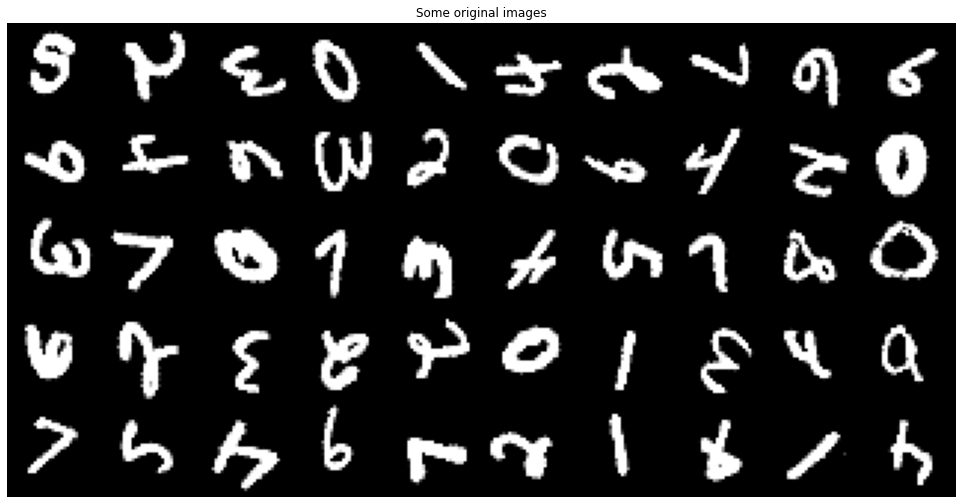

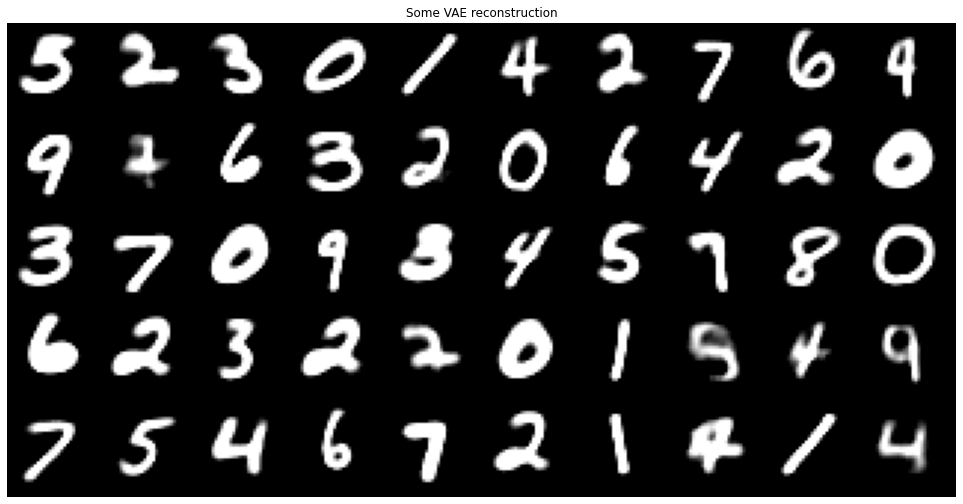

In [90]:
# Set to eval mode.
gcnn_vae.eval()   
# Retrive test images.
images, _ = iter(test_dataloader).next()
# Obtain reconstructed images.
reconstruced_images = rec_image(images, gcnn_vae)

# First visualise the original images.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images[0:50],10,0).permute(1, 2, 0))
plt.title("Some original images")
plt.axis('off')
plt.show()
# Then the reconstruted one.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(reconstruced_images[0:50].cpu(), 10, 0).permute(1, 2, 0))
plt.title("Some VAE reconstruction")
plt.axis('off')
plt.show()

## Performance on a continuous rotation of the input ($\forall$ latent dimension)

Here I rotate continuously the input digit and see what is the recostructed image generated by the VAE.\
Here the plot is made usig $\beta$ = 0.1 and latent dimension = 6.

In [30]:
# Build a dictionary label2images 
def label2images(dataloader):
    from collections import defaultdict
    label2img = defaultdict(list)
    for img_batch, label_batch in dataloader:
        for i in range(img_batch.shape[0]):
            # Mantain the singleton batch dimension with [i].
            label2img[label_batch[i].item()].append(img_batch[[i], ...])
    return label2img

In [50]:
# Download a non rotated test set in order to perform rotation from 0 to 360 degrees.
transf_test = transforms.Compose([
    transforms.ToTensor(),
    pad,
])
# MNIST dataset.
test_set_rot = MNIST(root='./data', download=True, train=False, transform=transf_test)
test_loader = DataLoader(test_set_rot, batch_size=batch_size, shuffle=True)

label2img_test_rot = label2images(test_loader) # Obtain the dictionary of the data and the label in the test set.
n_rotation = 32 # Fix the number of rotation.

imgs = []
for i in range(10):
    m = np.random.randint(low=0, high=len(label2img_test_rot[i]))
    x = label2img_test_rot[i][m].squeeze()
    imgs.append(x)
    
# Create a stack of all the images from to 0 to 9.
imgs = torch.stack(imgs)
# Get a set of angles by which to rotate the images.
rots = torch.linspace(0, 360 - 360/n_rotation, n_rotation)
# Rotate the input image and normalize it.
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(imgs, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)
# In rot_digit we have a tensor (n_rot, batch, H, W).

In [51]:
# Now I obtain the recostructed images by te model.
# Since the model take images of dimension (B, C, H, W),
# I have to reshape the rot_digit and unsqueeze it for the channel dimension.
rot_digits = torch.unsqueeze(rot_digit.reshape(len(rots)*10, 32, 32), dim=0).permute(1,0,2,3) # (B, C, H, W)
reconstructed = rec_image(rot_digits, gcnn_vae)

In [52]:
# Now I make a grid with rotated and reconstructed images.
rot_digits_stack = torchvision.utils.make_grid(rot_digits.cpu(), 10, 0).permute(1, 2, 0)[:,:,0]
recostructed_stack = torchvision.utils.make_grid(reconstructed.cpu(), 10, 0).permute(1, 2, 0)[:,:,0]

# define the sublots.
fig = make_subplots(rows = 2, cols=1,
                    specs=[[{'type': 'xy'}], [{'type': 'xy'}]])

fig.add_trace(go.Heatmap(z=rot_digits_stack[0:32], colorscale='Greys',
                         showscale=False), row=1, col=1)

fig.add_trace(go.Heatmap(z=recostructed_stack[0:32], colorscale='Greys',
                         showscale=False), row=2, col=1)

# Define frames.
frames = [dict(
    name=k,
    data=[go.Heatmap(z=rot_digits_stack[32*k:32*(k+1)], showscale=False),
          go.Heatmap(z=recostructed_stack[32*k:32*(k+1)], showscale=False)],
          traces=[0,1]) for k in range(len(rots))]


# Play button.
updatemenus = [dict(type='buttons',
                    buttons=[dict(label='Play',
                                  method='animate',
                                  args=[[f'{k}' for k in range(len(rots))],
                                        dict(frame=dict(duration=100, redraw=True),
                                             transition=dict(duration=0),
                                             easing='linear',
                                             fromcurrent=True,
                                             mode='immediate'
                                             )]),
                             dict(label='Pause',
                                  method='animate',
                                  args=[[None],
                                        dict(frame=dict(duration=0, redraw=False),
                                             transition=dict(duration=0),
                                             mode='immediate'
                                             )])
                             ],
                    direction='left',
                    pad=dict(r=10, t=85),
                    showactive=True, x=0.1, y=0, xanchor='right', yanchor='top')
               ]


# Slider.
sliders = [{'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {'font': {'size': 12}, 'prefix': 'Frame: ', 'visible': True, 'xanchor': 'right'},
            'transition': {'duration': 0, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9, 'x': 0.1, 'y': 0,
            'steps': [{'args': [[k], {'frame': {'duration': 0, 'easing': 'linear', 'redraw': False},
                                      'transition': {'duration': 0, 'easing': 'linear'}}],
                       'label': k, 'method': 'animate'} for k in range(len(rots))
                      ]}]

fig.update_yaxes(autorange="reversed", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=2, col=1)
fig.update(frames=frames),
fig.update_layout(title = "Rotation by 360 degrees of the input",
                  hovermode="closest",
                  width=800, height=400, 
                  showlegend = False,
                  updatemenus=updatemenus,
                  sliders=sliders)
iplot(fig)

# Geodesic transformation (possible only when latent dimension = 3)

Now I investigate the interpolation between digits along the sphere through geodesic path.

In [31]:
# Choose the number of interpolation, the starting point and the ending point.
num_interpolations = 50 
start_digit = 9
end_digit = 3

In [32]:
label2img_valid = label2images(valid_dataloader) # Obtain the dictionary of the data and the label in the validation set.

In [33]:
# How many styles are present in the last batch for a given number?
print("Number of styles for the starting digit: {}".format(len(label2img_valid[start_digit])))
print("Number of styles for the ending digit: {}".format(len(label2img_valid[end_digit])))

Number of styles for the starting digit: 503
Number of styles for the ending digit: 511


In [34]:
# Choose the digit style for both the number.
digit_style1 = 500
digit_style2 = 235

In [35]:
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.visualization.hypersphere import Circle, Sphere
import geomstats.backend as gs
import geomstats.visualization as visualization

# Here I implement the geodesic interpolation along the sphere.
def interpolation_geodesic(model, x_1, x_2, num_interpolations):
    # Define the hypersphere and its metrics.
    hs = Hypersphere(dim=latent_dim)
    hs_metric = hs.metric
    
    # Pick a sample and get its latent.
    model.to(device)
    model.float().eval()
    with torch.no_grad():
        x_1 = x_1.to(device)
        x_2 = x_2.to(device)
        z_1, _ = model.encoder(x_1.reshape(1,1,32,32))
        z_2, _ = model.encoder(x_2.reshape(1,1,32,32))

    # Set z_1 as initial point and z_2 as the final point.
    initial_point = gs.array(z_1.cpu())
    final_point = gs.array(z_2.cpu())
    # Create the geodesic between the two latent point.
    geodesic = hs_metric.geodesic(initial_point=initial_point, end_point=final_point)
    n_steps = num_interpolations
    t = gs.linspace(0.0, 1.0, n_steps)
    points = geodesic(t)
    pointes = torch.from_numpy(points).float()
    # Images associated to the latent point on the geodesic.
    with torch.no_grad():
        pointes = pointes.to(device)
        model = model
        reconstructed_image = gcnn_vae.decoder(pointes)
        recon=reconstructed_image.cpu()
        
    return recon, pointes

In [36]:
#  Initial image and final image.
x_1 = label2img_valid[start_digit][digit_style1]
x_2 = label2img_valid[end_digit][digit_style2]

# Retrive the reconstructed images and corresponding latent point.
recon, points = interpolation_geodesic(gcnn_vae, x_1, x_2, num_interpolations)
points = points.cpu()

# Meshgrid of a sphere surface.
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

# Define the sublots.
fig = make_subplots(rows = 1, cols=2,
                    specs=[[{'type': 'scene'}, {'type': 'xy'}]])

fig.add_trace(go.Scatter3d(visible=True,
                           x = points[:,0], y = points[:,1], z = points[:,2],
                           mode="lines",
                           line=dict(color='white', width=10),
                           name='Geodesic'
                           ), row=1, col=1)

fig.add_trace(go.Scatter3d(visible=True,
                           x = points[:,0], y = points[:,1], z = points[:,2],
                           mode="lines",
                           line=dict(color='white', width=10),
                           name='Geodesic'
                           ), row=1, col=1)

fig.add_trace(go.Surface(visible=True, 
                         x = x, y = y, z =z, opacity=0.5, 
                         contours = {"z": {"show": True, "start": -1, "end": 1, "size": 0.1, "width": 1}},
                         colorscale='Twilight', showscale=False
                         ), row=1, col=1)

fig.add_trace(go.Heatmap(z=recon[0,...].reshape(32,32), colorscale='Greys',
                         showscale=False), row=1, col=2)

# Define frames.
frames = [dict(
    name=k,
    data=[go.Scatter3d(visible = True,
                       x = [points[k,0]], 
                       y = [points[k,1]], 
                       z = [points[k,2]],
                       mode="markers",
                       marker = dict(size = 10, color = 'white')),
          go.Heatmap(z=recon[k,...].reshape(32,32), showscale=False)],
          traces=[0,3]) for k in range(len(points[:,...]))]


# Play button.
updatemenus = [dict(type='buttons',
                    buttons=[dict(label='Play',
                                  method='animate',
                                  args=[[f'{k}' for k in range(len(points[:,...]))],
                                        dict(frame=dict(duration=50, redraw=True),
                                             transition=dict(duration=0),
                                             easing='linear',
                                             fromcurrent=True,
                                             mode='immediate'
                                             )]),
                             dict(label='Pause',
                                  method='animate',
                                  args=[[None],
                                        dict(frame=dict(duration=0, redraw=False),
                                             transition=dict(duration=0),
                                             mode='immediate'
                                             )])
                             ],
                    direction='left',
                    pad=dict(r=10, t=85),
                    showactive=True, x=0.1, y=0, xanchor='right', yanchor='top')
               ]


# Slider.
sliders = [{'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {'font': {'size': 12}, 'prefix': 'Frame: ', 'visible': True, 'xanchor': 'right'},
            'transition': {'duration': 0, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9, 'x': 0.1, 'y': 0,
            'steps': [{'args': [[k], {'frame': {'duration': 0, 'easing': 'linear', 'redraw': False},
                                      'transition': {'duration': 0, 'easing': 'linear'}}],
                       'label': k, 'method': 'animate'} for k in range(len(points[:,...]))
                      ]}]

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update(frames=frames),
fig.update_layout(title = "Geodesic path on a sphere from {} to {}".format(start_digit, end_digit),
                  hovermode="closest",
                  width=1000, height=600, 
                  showlegend = False,
                  updatemenus=updatemenus,
                  sliders=sliders)
iplot(fig)

# Sampling from the flat Gaussian distribution Vs the von Mises–Fisher distribution ($\forall$ latent dimension)

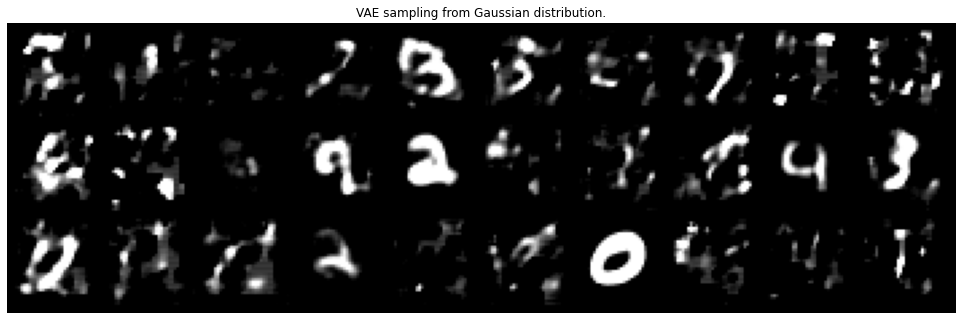

In [110]:
# Example of sampling from a Gaussian distribution (mean=0. and std=1.).
latent_mu = torch.distributions.Normal(torch.zeros(30,latent_dim), torch.ones(30,latent_dim))
z = latent_mu.sample() # Now there is no need to use rsample() since we don't have to backpropagate.
gcnn_vae.eval()
gcnn_vae.cpu()
images_latent = gcnn_vae.decoder(z.cpu())

# Reconstruct and visualize the images using the vae.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images_latent[0:30], 10, 3).permute(1, 2, 0))
plt.title("VAE sampling from Gaussian distribution.")
plt.axis('off')
plt.show()

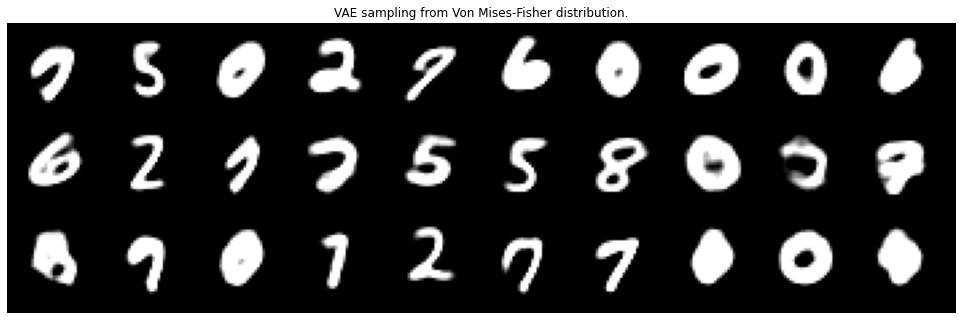

In [117]:
# Example of sampling from a von Mises-Fisher distribution.
r1 = -1000 # lower bound
r2 = 1000 # upper bound
latent_mu = (r2 - r1) * torch.rand(30, latent_dim) + r1
mu = latent_mu / latent_mu.norm(dim=-1, keepdim=True)
conc = F.softplus((r2 - r1) * torch.rand(30, 1) + r1) + 1

# Sample from the Von Mises-Fisher distribution.
q_z = VonMisesFisher(latent_mu, conc)
z = q_z.sample()
gcnn_vae.eval()
gcnn_vae.cpu()
images_latent = gcnn_vae.decoder(z)

# Reconstruct and visualize the images using the vae.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(images_latent[0:30], 10, 3).permute(1, 2, 0))
plt.title("VAE sampling from Von Mises-Fisher distribution.")
plt.axis('off')
plt.show()

# Interpolation following straight path Vs geodesic path ($\forall$ latent dimension)

In [84]:
# Define the function that interpolate from the initial lantent point to the final one.
def interpolation_line(lambda1, model, img1, img2):
    with torch.no_grad():
        model.to(device)
        # Latent vector of first image.
        _, _, z1, _ = model(img1.to(device))
        # Latent vector of second image.
        _, _, z2, _ = model(img2.to(device))
        # Lnterpolation of the two latent vectors.
        inter_latent = lambda1 * z2 + (1- lambda1) * z1
        # Reconstruct interpolated image.
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
        return inter_image

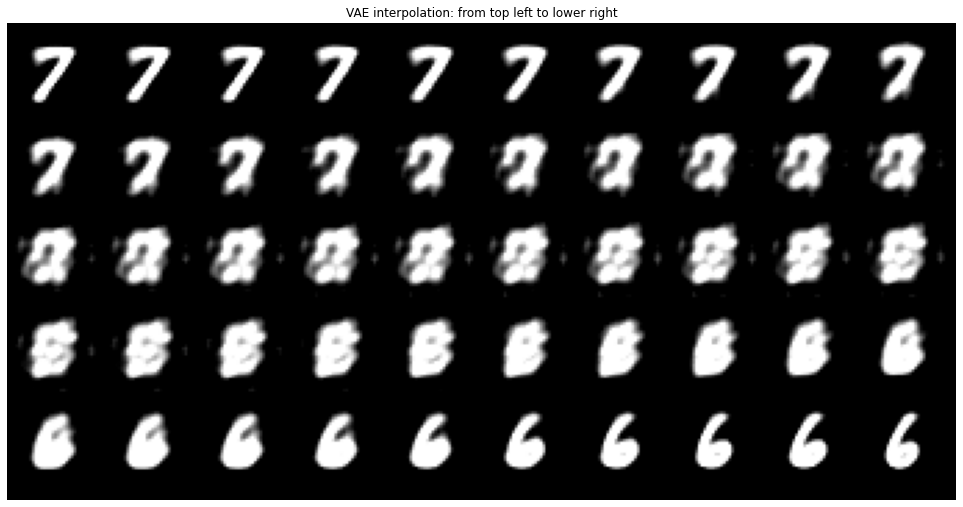

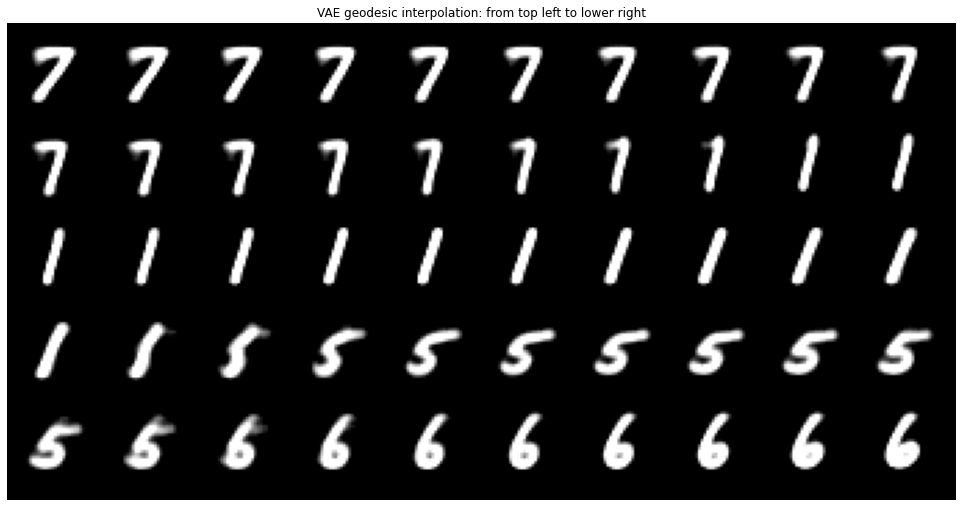

In [86]:
# Choose the number of interpolations,
# the starting digits,
# the ending digits
# and the style.
num_interpolations = 50
start_digit = 7
end_digit = 6
digit_style1 = 12
digit_style2 = 347

label2img_valid = label2images(valid_dataloader) # Obtain the dictionary of the data and the label in the valid set
start_image = label2img_valid[start_digit][digit_style1]
end_image = label2img_valid[end_digit][digit_style2]

# Interpolation lambdas.
lambda_range=np.linspace(0,1,num_interpolations)
bigimage = torch.cat([interpolation_line(x, gcnn_vae, start_image, end_image) for x in lambda_range])
# Geodesic interpolation
bigimage_geodesic = interpolation_geodesic(gcnn_vae, start_image, end_image, num_interpolations)

# Visualize the linear interpolation.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0))
plt.title("VAE interpolation: from top left to lower right")
plt.axis('off')
plt.show()

# Visualize the geodesic interpolation.
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage_geodesic[0], 10).permute(1, 2, 0))
plt.title("VAE geodesic interpolation: from top left to lower right")
plt.axis('off')
plt.show()